<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Resumen_de_textos_usando_seq2seq_LSTM_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANTE: Antes de iniciar cambiar entorno de ejecución a GPU

# Cargar bibliotecas y Embeddings preentrenados

In [1]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 9.5 MB/s 
     |████████████████████████████████| 106 kB 95.3 MB/s 


<h3>Bibliotecas<h3>

In [2]:
import pandas as pd
import numpy as np
import gensim
import contractions
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.data import Dataset  # Convierte conjuntos de datos de Python a tensores
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  # Crear diccionario para convertir palabras a indices y vs.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Rellenar con cero los vectores de las secuencias hasta la longitud máxima
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate #, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

<h3>Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3  palabras y frases en inglés. 
Crea un acceso directo en tu drive del modelo preentrenado que está disponible en este [enlace](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)


In [3]:
# asegurate de poner la ruta correcta en donde se ubica el archivo en tu drive
file =  '/content/drive/MyDrive/Embeddings/GoogleNews-vectors-negative300.bin.gz'  
w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)

In [4]:
print('Palabras en el modelo w2v: {:,} '.format(len(w2v.vocab)))
print('Dimensiones por embedding: ', w2v.vector_size)

Palabras en el modelo w2v: 3,000,000 
Dimensiones por embedding:  300


In [5]:
%%time
dic_embeddings_word2vec  = {palabra : w2v[palabra] for palabra in w2v.index2word}

CPU times: user 5.96 s, sys: 361 ms, total: 6.32 s
Wall time: 6.3 s


# Funciones

In [3]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [4]:
def Vectorizer(serie_pd, max_tokens= 20000):
    '''Crear diccionario para convertir palabras en índices
     '''
    text_ds = Dataset.from_tensor_slices(serie_pd).batch(128)  # transforma la serie a tensores
    vectorizer = TextVectorization(max_tokens = max_tokens  )  
    vectorizer.adapt(text_ds)   #similar a fit 
    return  vectorizer

In [5]:
def vectores_palabras(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    '''Obtiene una matriz donde cada renglón es el 'embedding vector' de una 
    palabra del vocabulario '''
    num_tokens = len(dic_vocabulario.keys()) 
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # los vectores no encontrados en el embeding se quedan en cero
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [88]:
def crea_resumen(input_seq):
    # Codifica el texto como vectores de entrada
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Genera una secuencia vacía de longitud 1.
    target_seq = np.zeros((1,1))

    # Identifica la palabra 'tokenstart' como la primera palabra de la secuencia objetivo
    target_seq[0, 0] =  palabras_indices_resumen['tokenstart']
    stop_condition = False
    decoded_sentence = ''
    t=0
    sampled_token = ''
    while stop_condition == False:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Escoje la próxima palabra para el resumen
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = indices_palabras_resumen[sampled_token_index]

        # Mientras la palabra elejida no sea la final 'tokenend', anexa la palabra elejida al resumen
        if sampled_token!='tokenend':
            decoded_sentence += ' '+ sampled_token

        # Sal del ciclo while si se alcanza la longitud máxima o si se encuentra 'tokenend'.
        if (sampled_token == 'tokenend' or t >= (longitud_max_resumen-1)):
            stop_condition = True

        # Actualiza la secuencia objetivo (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza los estados internos para predecir la siguiente palabra, igualandolos al estado del tiempo anterior
        e_h, e_c = h, c
        t+=1

    return decoded_sentence

In [7]:
def seq2summary(input_seq):
    '''obtiene el resumen, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if((i != 0 and i != palabras_indices_resumen['tokenstart']) and i != palabras_indices_resumen['tokenend']):
        newString = newString + indices_palabras_resumen[i]+' '
    return newString

def seq2text(input_seq):
    '''obtiene la reseña, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + indices_palabras_reseña[i]+' '
    return newString

# Lectura de Datos y preparación de secuencias

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Datos/AmazonReviews/Reviews.csv',
                 nrows=500000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(353877, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [12]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 137851
Wheeeee!!!!!!!!!!!!!!!
I used it for the first time this morning.  Great rise.  Great texture.  I've been unhappy with grocery store yeast but NOW I KNOW I can bake.  I've got it stuck in the freezer and looking at what to bake next.

Review # 326802
Horrible waste of packaging. Very expensive.
This is one of the worst ideas I've ever seen. The wastefulness of this packaging is incredible. By buying this item you are contributing to filling of landfills, environmental destruction, and overwhelming inefficiency. Furthermore, on a per-ounce basis this item is considerably more expensive than cheese in large canisters. Avoid this silly product if you care about the environment or your wallet!

Review # 269994
Great breakfast and snack
This is the only breakfast cereal I can get all three kids to eat.  In fact when it comes in I have to put their names on the boxes so the oldest does not plough through her two (allocated) boxes within four days.  The kids eat this for dese

## Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [13]:
%%time
for col in df.columns:
  df[col] = df[col].apply(preprocesar)


CPU times: user 25.3 s, sys: 155 ms, total: 25.5 s
Wall time: 25.5 s


## Agregar token que identifique el inicio y el final de la secuencia objetivo (resúmenes).

In [14]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [15]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 11525
tokenstart yummmmmmmy finally great eggnog year round  tokenend
wish i could get this on auto ship wonderful product wonderful flavor and wonderful to be able to have it whenever we want 

Review # 66217
tokenstart did not love them tokenend
i thought these were really dry i definitely need a cup of coffee to wash them down i guess they are ok to throw in a bag to take with you in place of an energy bar or something i doubt i will buy again though 

Review # 16688
tokenstart good chocolate fix for gf eaters tokenend
i followed the recipe exactly after freezing them i have to admit i used a butter knife to try to cut it and i broke the knife ha nonetheless they were yummy 

Review # 284531
tokenstart the new mars candy bar tokenend
my husband and i recently came across the mars bars for sale at world market in oakbrook terrace illinois we bought a number of these mars bars which were produced in poland we felt they were delicious but they did not seem exactly like the on

## Fijar longitud máxima de palabras en textos y resumenes

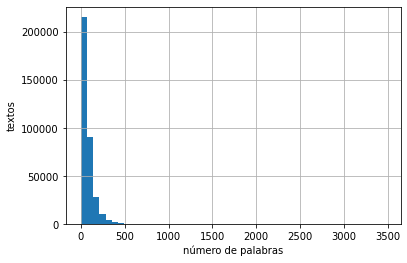


El 90% de los textos tiene 164 palabras


In [16]:
# ¿Cuantas palabras tienen cada texto?
palabras_reseña = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_reseña.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_reseña.quantile(0.90)))

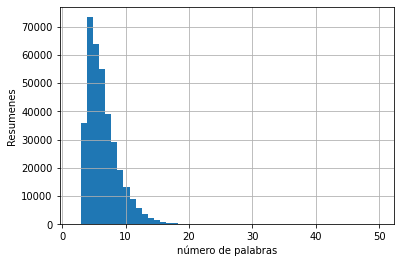


El 97.5% de los resumenes tiene 13 palabras


In [17]:
# ¿Cuantas palabras tienen cada titulo?
palabras_resumen = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_resumen.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("Resumenes")
plt.show()

print('\nEl 97.5% de los resumenes tiene {:,.0f} palabras'.format(palabras_resumen.quantile(0.975)))

In [18]:
longitud_max_reseña = palabras_reseña.quantile(0.90)     #164 palabras
longitud_max_resumen = palabras_resumen.quantile(0.975)  # 13 palabras

In [19]:
datos =  df[(palabras_reseña <= longitud_max_reseña ) & (palabras_resumen <= longitud_max_resumen)]
datos.shape   

(314849, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [20]:
x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)
print('{} reseñas en el conjunto de entrenamiento\n{} reseñas en el conjunto de prueba'.format(len(x_train), len(x_test)))

283364 reseñas en el conjunto de entrenamiento
31485 reseñas en el conjunto de prueba


# Preparar las secuencias para ingresar al modelo

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


### 1)  Identificar cada palabra con un valor numérico

In [21]:
%%time
vectorizer_reseña = Vectorizer(x_train)

# Diccionarios de la secuencia de entrada
voc_reseña = vectorizer_reseña.get_vocabulary()  # lista con el vocabulario
palabras_indices_reseña = dict(zip(voc_reseña, range(len(voc_reseña))))
indices_palabras_reseña = dict(map(reversed, palabras_indices_reseña.items()))

CPU times: user 6.83 s, sys: 319 ms, total: 7.15 s
Wall time: 7.16 s


In [22]:
palabras_indices_reseña.keys()

dict_keys(['', '[UNK]', 'the', 'i', 'and', 'a', 'it', 'to', 'is', 'this', 'of', 'not', 'for', 'in', 'my', 'have', 'that', 'but', 'are', 'you', 'with', 'was', 'they', 'as', 'on', 'like', 'so', 'these', 'them', 'good', 'great', 'very', 'taste', 'product', 'will', 'be', 'at', 'just', 'one', 'or', 'do', 'flavor', 'coffee', 'if', 'all', 'would', 'am', 'we', 'love', 'from', 'tea', 'can', 'when', 'has', 'had', 'more', 'me', 'than', 'amazon', 'out', 'get', 's', 'no', 'really', 'other', 'too', 'some', 'only', 'up', 'much', 'use', 'were', 'about', 'price', 'buy', 'best', 'food', 'time', 'little', 'find', 'an', 'there', 'because', 'also', 'tried', 'what', 'your', 'make', 'been', 'better', 'did', 'well', 'does', 'even', 'try', 'chocolate', 'by', 'now', 'which', 'after', 'any', 'eat', 'again', 'he', 'she', 'bought', 'used', 'sugar', 'found', 'could', 'sweet', 'our', '2', 'first', 'cannot', 'free', 'order', 'delicious', 'tastes', 'store', 'drink', 'made', 'water', 'box', 'bag', 'cup', 'their', 'way'

[UNK] es un token especial que se usara cuando se encuentren palabras que no están en el vocabulario.

In [23]:
vectorizer_resumen = Vectorizer(y_train)
# Diccionarios de la secuencia de entrada
voc_resumen = vectorizer_resumen.get_vocabulary()  # lista con el vocabulario
palabras_indices_resumen = dict(zip(voc_resumen, range(len(voc_resumen))))
indices_palabras_resumen = dict(map(reversed, palabras_indices_resumen.items()))


In [24]:
ejemplos = x_train.iloc[:2]
for ej in ejemplos:
  print(len(ej.split()))
  print(ej)

16
my husband s favorite biscuit cookie with tea plain but tasty hard to find in america 
44
i received this coffee as a bunco prize i love coffee but tend to dislike flavored coffee due to the strange aftertaste so many leave behind this coffee had great flavor and no aftertaste i definitely recommend it i am searching for more now 


In [25]:
ejemplos_vec = ejemplos.apply(vectorizer_reseña)
for ej in ejemplos_vec:
  print(len(ej))
  print(ej)

16
tf.Tensor(
[  14  312   61  135 2479  485   20   50  526   17  199  185    7   79
   13 2340], shape=(16,), dtype=int64)
44
tf.Tensor(
[   3  280    9   42   23    5    1 6590    3   48   42   17 1194    7
 2787  341   42  710    7    2 1365  572   26  146  716 2269    9   42
   54   30   41    4   62  572    3  205  129    6    3   46 1351   12
   55   97], shape=(44,), dtype=int64)


In [26]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_resumen)
y_test_vec = y_test.apply(vectorizer_resumen)

CPU times: user 35min 55s, sys: 12.8 s, total: 36min 8s
Wall time: 36min 5s


## 2) Rellenar cada secuencia hasta alcanzar la longitud máxima

In [27]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

ejemplos_seq =  pad_sequences(ejemplos_vec, maxlen = int(longitud_max_reseña), padding='post')
for ej in ejemplos_seq:
  print(len(ej))
  print(ej)

164
[  14  312   61  135 2479  485   20   50  526   17  199  185    7   79
   13 2340    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
164
[   3  280    9   42   23    5    1 6590    3   48   42   17 1194    7
 2787  341   42  710    7    2 1365  572   26  146  716 2269    9   42
   54   30   41  

In [28]:
%%time

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_reseña), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_reseña), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_resumen) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_resumen) , padding='post') 

CPU times: user 2min 2s, sys: 570 ms, total: 2min 3s
Wall time: 2min 3s


## 3) Obtener la matriz de vectores para todas las palabras del vocabulario 

In [29]:
embedding_matrix_reseña = vectores_palabras(palabras_indices_reseña, dic_embeddings_word2vec , 300)
embedding_matrix_reseña.shape

17825 palabras vectorizadas, que representan 89.1% de todas las palabras en el corpus


(20000, 300)

In [30]:
embedding_matrix_resumen = vectores_palabras(palabras_indices_resumen, dic_embeddings_word2vec , 300)
embedding_matrix_resumen.shape

14580 palabras vectorizadas, que representan 72.9% de todas las palabras en el corpus


(20000, 300)

## Guardamos en pickle los avances

In [12]:
import pickle
path = '/content/drive/MyDrive/Pikles/Pickle_ Datos entrada RNN/'
tuple_inputs = ((embedding_matrix_resumen, embedding_matrix_reseña),
                (x_train_seq, x_test_seq,  y_train_seq, y_test_seq),
                (palabras_indices_resumen, palabras_indices_reseña),
                (indices_palabras_resumen, indices_palabras_reseña),
                (longitud_max_resumen, longitud_max_reseña)
                )
pickle.dump(tuple_inputs, open (path + "tuple_inputs_RNN_v2207_.pkl", 'wb'))

# Leemos los datos guardados

In [13]:
import pickle
path = '/content/drive/MyDrive/Pikles/Pickle_ Datos entrada RNN/'
tuple_inputs = pickle.load(open(path + "tuple_inputs_RNN_v2207_.pkl", 'rb'))

embedding_matrix_resumen, embedding_matrix_reseña = tuple_inputs[0]
x_train_seq, x_test_seq,  y_train_seq, y_test_seq = tuple_inputs[1]
palabras_indices_resumen, palabras_indices_reseña = tuple_inputs[2]
indices_palabras_resumen, indices_palabras_reseña = tuple_inputs[3]
longitud_max_resumen,     longitud_max_reseña     = tuple_inputs[4]


# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## ENCODER  y DECODER


In [ ]:
num_tokens_reseña = len(palabras_indices_reseña) 
num_tokens_resumen = len(palabras_indices_resumen)
embedding_dim = 300

In [26]:
K.clear_session() 
latent_dim = 320  # neuronas ocultas en cada LSTM en cada tiempo t.

# ENCODER   ================================================================

## EMBEDDING
#recibe los indices que corresponden a las palabras de las reseñas y las 
#regresa con el vector correpondiente del embedding

encoder_inputs = Input(shape = (int(longitud_max_reseña),))

enc_emb_lay = Embedding(num_tokens_reseña, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_reseña),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)     

#LSTM 1
# procesa la secuencia de entrada y regresa otra secuencia que pasara a la
# capa LSTM 2 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara a la capa LSTM 3
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara al mecanismo de atención y los estados h y c inicializarán
# el decodificador.

encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2) 


# DECODIFICADOR ================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_resumen, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_resumen),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




## Mecanismo de atención

 [Fuente ](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

In [27]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.Attention()

  def call(self, query, value,
          #  mask
           ):
    # shape_checker = ShapeChecker()
    # shape_checker(query, ('batch', 't', 'query_units'))
    # shape_checker(value, ('batch', 's', 'value_units'))
    # shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    # shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    # shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    # value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        # mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    # shape_checker(context_vector, ('batch', 't', 'value_units'))
    # shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [28]:
attention = BahdanauAttention(latent_dim)

In [29]:
context_vector, attention_weights = attention(decoder_outputs, encoder_outputs) # (query, value)

In [30]:
# Unión del decoder con la capa de atención

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, context_vector])

# El Decoder calcula su salida mediante Softmax, que crea el vector de probabilidad 
# para determinar la secuencia final.

decoder_dense = TimeDistributed(Dense(embedding_matrix_resumen.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Modelo de entrenamiento

In [31]:
# Modelo definitivo

# Tupla con las entradas y las salidas
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 



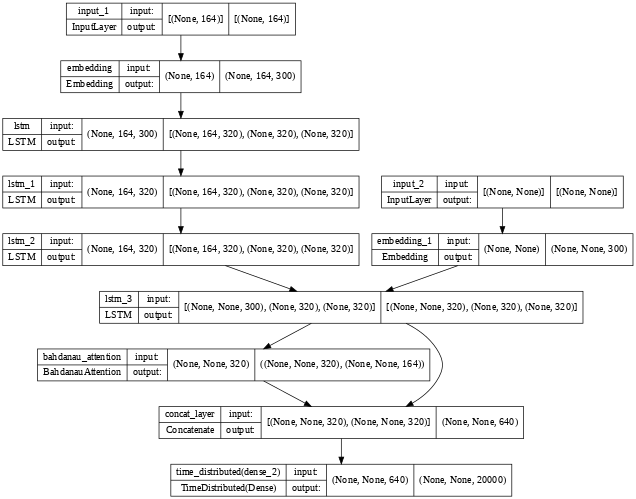

In [32]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 164)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 164, 300)     6000000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 164, 320),   794880      ['embedding[0][0]']              
                                 (None, 320),                                                     
                                 (None, 320)]                                                     
                                                                                              

### Entrenamiento

In [34]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [35]:
#%%time

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 12,
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/12
554/554 [==============================] - 222s 381ms/step - loss: 2.2245 - val_loss: 1.9403
Epoch 2/12
554/554 [==============================] - 209s 378ms/step - loss: 1.8936 - val_loss: 1.8074
Epoch 3/12
554/554 [==============================] - 209s 378ms/step - loss: 1.7670 - val_loss: 1.7120
Epoch 4/12
554/554 [==============================] - 209s 378ms/step - loss: 1.6847 - val_loss: 1.6567
Epoch 5/12
554/554 [==============================] - 209s 378ms/step - loss: 1.6283 - val_loss: 1.6236
Epoch 6/12
554/554 [==============================] - 209s 378ms/step - loss: 1.5889 - val_loss: 1.5940
Epoch 7/12
554/554 [==============================] - 210s 379ms/step - loss: 1.5545 - val_loss: 1.5715
Epoch 8/12
554/554 [==============================] - 210s 378ms/step - loss: 1.5248 - val_loss: 1.5660
Epoch 9/12
554/554 [==============================] - 210s 378ms/step - loss: 1.4978 - val_loss: 1.5407
Epoch 10/12
554/554 [==============================] - 210s 378m

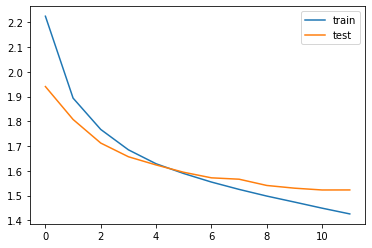

In [36]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [52]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
model.save_weights('/content/drive/MyDrive/Modelos/WeightsM_rev-220727')

In [53]:
model.load_weights('/content/drive/MyDrive/Modelos/WeightsM_rev-220727')

#Modelo de Inferencia y Generación de Texto

In [37]:
## Inferencia del codificador
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

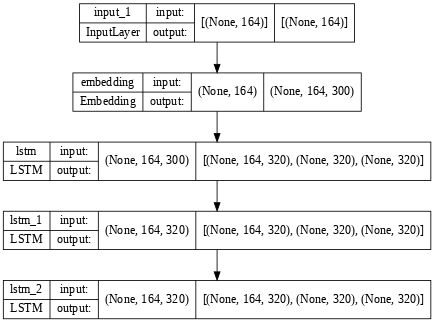

In [38]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

In [39]:
# Inferencia del decodificador

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_reseña), latent_dim))

# Obtener los embeddings de la secuencia del decodificador 
dec_emb2 = dec_emb_layer(decoder_inputs)

# Para predecir la siguiente palabra, el estado inicial se iguala al estado del tiempo anterior
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Inferencia en modulo de atención
attention = BahdanauAttention(latent_dim)
context_vector, _ = attention( decoder_outputs2, decoder_hidden_state_input,)
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, context_vector])

# Se utiliza la capa con activación softmax para generar la distribución de probabilidad del vocabulario objetivo
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Modelo final del decoder
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

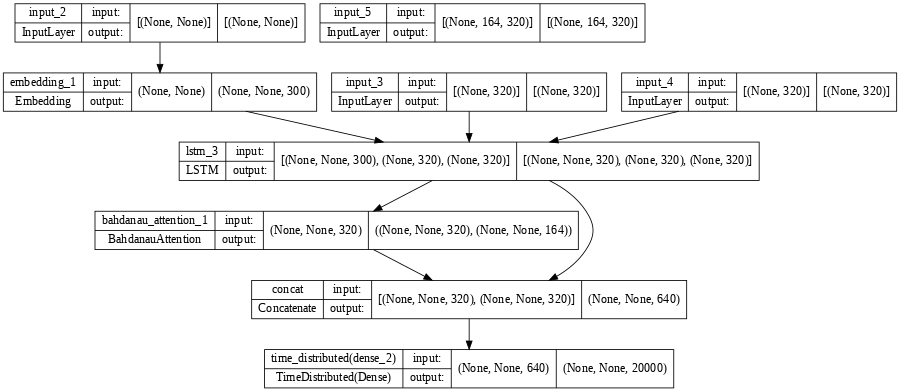

In [40]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

## Predicciones


**Implementación del modelo de inferencia **
[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

<h3> Comparación del resumen generado por la rnn con el resumen original

In [86]:
for i in range(105,120):
  print(i)
  print("Reseña:",seq2text(x_test_seq[i]))
  print("Resumen original:",seq2summary(y_test_seq[i]))
  print("Resumen generado:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

105
Reseña: thin runny and the fake milk powder used to add creaminess has an off flavor better off eating your ceramic mug 
Resumen original: not good 
Resumen generado:  cet [UNK]           


106
Reseña: this is a really strong wonderful coffee not bitter in any way it is the only one we drink now great product 
Resumen original: great coffee 
Resumen generado:  great coffee


107
Reseña: i love this stuff and it is hard to find sugar free makes it good for me i recommend it highly even my husband likes it and plans to have me send him off to the [UNK] golf course with a thermos full of this along with a flash of tequila or brandy lol 
Resumen original: perfect for the cold weather 
Resumen generado:  love it


108
Reseña: a neighbor gave me 2 cans and my cat loved it ate it a few times but then only drank the broth donated the remaining 22 cans to my local animal shelter 
Resumen original: she is a cat 
Resumen generado:  excellant product


109
Reseña: all of the land o lakes coco